In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from datetime import datetime, timedelta


import regex as re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger

import string
import math

from xgboost import XGBClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import KFold
#from sklearn.grid_search import GridSearchCV
%matplotlib inline
pd.set_option('display.max_columns', None, 'display.max_rows', None) 

ModuleNotFoundError: No module named 'textblob'

In [35]:
df = pd.read_csv('hardware_societe_name_date_location_stars_reviews.csv', index_col=None, parse_dates=True, infer_datetime_format=True, date_parser=True)

In [36]:
df.head()

,Unnamed: 0,name,date,location,star_ratings,reviews
0,0,Saif A.,2/13/2019,"Vancouver, Canada",5 star rating,The taste was amazing and the bun was spectacu...
1,1,Katerina K.,1/20/2020,"Foster City, CA",4 star rating,Cute place for breakfast or brunch.Note 1: th...
2,2,David L.,10/29/2019,"Garden Grove, CA",3 star rating,We came here at about 11:30am on Wednesday and...
3,3,Leah M.,12/28/2018,"Los Angeles, CA",5 star rating,Quite possibly the best breakfast I've ever ha...
4,4,Zeny M.,6/20/2019,"Markham, Canada",5 star rating,Walked 25 minutes to have breakfast here and g...


In [37]:
df.drop(columns='Unnamed: 0', inplace=True)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          210 non-null    object
 1   date          210 non-null    object
 2   location      210 non-null    object
 3   star_ratings  210 non-null    object
 4   reviews       210 non-null    object
dtypes: object(5)
memory usage: 8.3+ KB


In [39]:
# Displaying details of the dataset
print("Shape of the dataset:")
print(df.shape, '\n')

print("Column names:")
print(df.columns, '\n')

print("Datatype of each column:")
print(df.dtypes, '\n')

print("Few dataset entries:")
print(df.head(), '\n')

df.describe(include='all')

Shape of the dataset:
(210, 5) 

Column names:
Index(['name', 'date', 'location', 'star_ratings', 'reviews'], dtype='object') 

Datatype of each column:
name            object
date            object
location        object
star_ratings    object
reviews         object
dtype: object 

Few dataset entries:
          name        date           location   star_ratings  \
0      Saif A.   2/13/2019  Vancouver, Canada  5 star rating   
1  Katerina K.   1/20/2020    Foster City, CA  4 star rating   
2     David L.  10/29/2019   Garden Grove, CA  3 star rating   
3      Leah M.  12/28/2018    Los Angeles, CA  5 star rating   
4      Zeny M.   6/20/2019    Markham, Canada  5 star rating   

                                             reviews  
0  The taste was amazing and the bun was spectacu...  
1  Cute place  for breakfast or brunch.Note 1: th...  
2  We came here at about 11:30am on Wednesday and...  
3  Quite possibly the best breakfast I've ever ha...  
4  Walked 25 minutes to have breakf

,name,date,location,star_ratings,reviews
count,210,210,210,210,210
unique,210,199,109,5,210
top,Feren Y.,11/23/2015,"Melbourne, Australia",5 star rating,"Fabulous coffee. Great eggs - baked eggs, Lobs..."
freq,1,3,47,111,1


# Exploring the data

In [40]:
df.location.value_counts()

Melbourne, Australia               47
San Francisco, CA                  11
Australia                           9
Sydney, Australia                   7
Brisbane, Australia                 5
Markham, Canada                     4
Seattle, WA                         4
Perth, Australia                    4
Toronto, Canada                     3
New York, NY                        3
Adelaide, Adelaide, Australia       2
Paris, France                       2
Washington, DC                      2
Richmond, Australia                 2
Los Angeles, CA                     2
Vancouver, Canada                   2
Manhattan, NY                       2
Wellington, New Zealand             2
Melbourne, Melbourne, Australia     2
Adelaide, Australia                 2
London, United Kingdom              2
Garden Grove, CA                    2
Preston, Australia                  2
Auckland, New Zealand               2
Richmond Hill, Canada               1
Hawthorn East, Australia            1
Canberra, Au

In [41]:
df.star_ratings.value_counts()

5 star rating    111
4 star rating     72
3 star rating     13
2 star rating      8
1 star rating      6
Name: star_ratings, dtype: int64

In [42]:
df['length'] = df['reviews'].apply(len)
df.head()

,name,date,location,star_ratings,reviews,length
0,Saif A.,2/13/2019,"Vancouver, Canada",5 star rating,The taste was amazing and the bun was spectacu...,97
1,Katerina K.,1/20/2020,"Foster City, CA",4 star rating,Cute place for breakfast or brunch.Note 1: th...,430
2,David L.,10/29/2019,"Garden Grove, CA",3 star rating,We came here at about 11:30am on Wednesday and...,692
3,Leah M.,12/28/2018,"Los Angeles, CA",5 star rating,Quite possibly the best breakfast I've ever ha...,591
4,Zeny M.,6/20/2019,"Markham, Canada",5 star rating,Walked 25 minutes to have breakfast here and g...,582


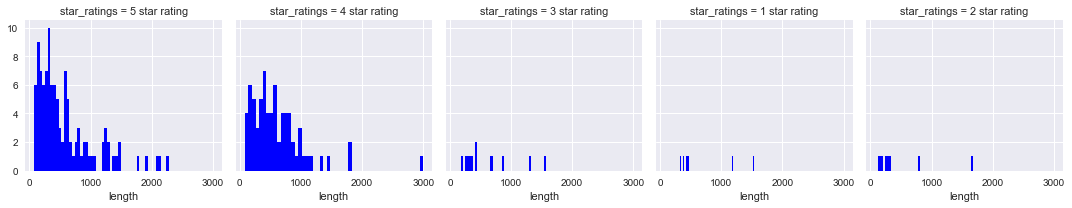

In [43]:
graph = sns.FacetGrid(data=df,col='star_ratings')
graph.map(plt.hist,'length',bins=50,color='blue')

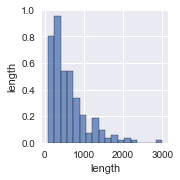

In [44]:
sns.pairplot(data=df)

Text(0.5, 1.0, 'Review Length')

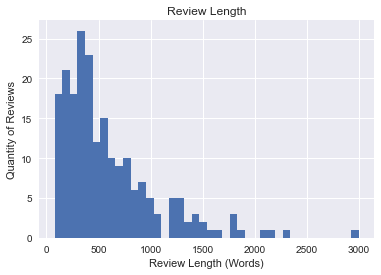

In [45]:
plt.hist(x='length', data=df, bins=40)
plt.xlabel('Review Length (Words)')
plt.ylabel('Quantity of Reviews')
plt.title('Review Length')

In [46]:
stars_length = df.groupby('star_ratings').mean()
stars_length

,length
star_ratings,
1 star rating,718.000000
2 star rating,478.125000
3 star rating,592.692308
4 star rating,616.250000
5 star rating,581.315315


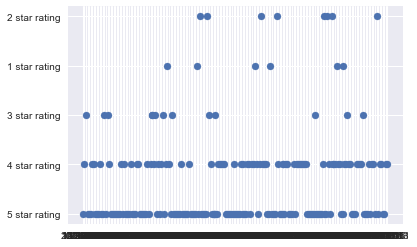

In [47]:
plt.scatter(x='date', y='star_ratings', data=df)

In [48]:
df.length.mean()

593.9714285714285

In [49]:
df.tail()

,name,date,location,star_ratings,reviews,length
205,Emilie P.,7/07/2016,"Ville de Québec, Canada",5 star rating,"Wow wow wow! Best brekky ever! Cute place, kin...",190
206,Alex F.,4/12/2016,"Seattle, WA",5 star rating,Eclectic mix of French and Mexican inspired br...,126
207,Kathryn B.,6/11/2013,"San Francisco, CA",5 star rating,I thought I was eating some good food in Melbo...,1250
208,Allan B.,10/16/2011,"Windermere, FL",4 star rating,"Well Hardware Lane is an interesting place, to...",825
209,Olivia H.,5/08/2013,"Melbourne, Australia",4 star rating,Hardware society was a hit and miss. Maybe I h...,941


In [50]:
# Indexing the stars to turn the column numeric for statistical manipulation
stars = []

for i in range(0,210):
    stars.append((df.iloc[i].star_ratings[0]))

stars

['5',
 '4',
 '3',
 '5',
 '5',
 '5',
 '4',
 '4',
 '5',
 '5',
 '5',
 '4',
 '5',
 '5',
 '3',
 '5',
 '3',
 '4',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '4',
 '5',
 '4',
 '5',
 '5',
 '5',
 '4',
 '5',
 '5',
 '5',
 '4',
 '4',
 '5',
 '5',
 '5',
 '5',
 '5',
 '4',
 '5',
 '4',
 '3',
 '4',
 '3',
 '5',
 '4',
 '5',
 '4',
 '3',
 '5',
 '4',
 '1',
 '4',
 '5',
 '3',
 '5',
 '5',
 '5',
 '5',
 '5',
 '4',
 '5',
 '5',
 '5',
 '5',
 '4',
 '5',
 '5',
 '5',
 '5',
 '1',
 '5',
 '2',
 '5',
 '5',
 '5',
 '5',
 '2',
 '3',
 '3',
 '4',
 '5',
 '5',
 '3',
 '5',
 '4',
 '4',
 '4',
 '4',
 '4',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '4',
 '4',
 '4',
 '5',
 '5',
 '4',
 '4',
 '5',
 '4',
 '4',
 '1',
 '4',
 '5',
 '4',
 '2',
 '4',
 '4',
 '4',
 '5',
 '5',
 '1',
 '5',
 '5',
 '5',
 '2',
 '4',
 '5',
 '5',
 '4',
 '5',
 '4',
 '4',
 '5',
 '5',
 '5',
 '5',
 '4',
 '5',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '4',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '4',
 '2',
 '3',
 '5',
 '5',
 '2',
 '4',
 '5'

In [51]:
df['stars'] = stars

In [52]:
df.stars.value_counts()

5    111
4     72
3     13
2      8
1      6
Name: stars, dtype: int64

In [53]:
df.head()

,name,date,location,star_ratings,reviews,length,stars
0,Saif A.,2/13/2019,"Vancouver, Canada",5 star rating,The taste was amazing and the bun was spectacu...,97,5
1,Katerina K.,1/20/2020,"Foster City, CA",4 star rating,Cute place for breakfast or brunch.Note 1: th...,430,4
2,David L.,10/29/2019,"Garden Grove, CA",3 star rating,We came here at about 11:30am on Wednesday and...,692,3
3,Leah M.,12/28/2018,"Los Angeles, CA",5 star rating,Quite possibly the best breakfast I've ever ha...,591,5
4,Zeny M.,6/20/2019,"Markham, Canada",5 star rating,Walked 25 minutes to have breakfast here and g...,582,5


In [54]:
df.drop(columns= 'star_ratings', inplace=True)

In [55]:
df.head()

,name,date,location,reviews,length,stars
0,Saif A.,2/13/2019,"Vancouver, Canada",The taste was amazing and the bun was spectacu...,97,5
1,Katerina K.,1/20/2020,"Foster City, CA",Cute place for breakfast or brunch.Note 1: th...,430,4
2,David L.,10/29/2019,"Garden Grove, CA",We came here at about 11:30am on Wednesday and...,692,3
3,Leah M.,12/28/2018,"Los Angeles, CA",Quite possibly the best breakfast I've ever ha...,591,5
4,Zeny M.,6/20/2019,"Markham, Canada",Walked 25 minutes to have breakfast here and g...,582,5


In [56]:
df['date'] = pd.to_datetime(df.date)

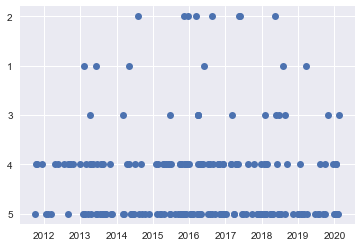

In [57]:
plt.plot_date(x=df.date, y=df.stars, xdate=True)

In [60]:
df.dtypes

name                object
date        datetime64[ns]
location            object
reviews             object
length               int64
stars               object
dtype: object

In [61]:
df['stars'] = pd.to_numeric(df['stars'])

In [62]:
df.dtypes

name                object
date        datetime64[ns]
location            object
reviews             object
length               int64
stars                int64
dtype: object

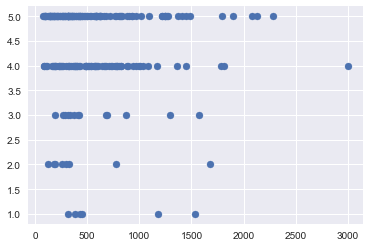

In [63]:
plt.scatter(x='length', y='stars', data=df)

In [64]:
reviewer_locations = df.location.value_counts()

In [65]:
display(reviewer_locations)

Melbourne, Australia               47
San Francisco, CA                  11
Australia                           9
Sydney, Australia                   7
Brisbane, Australia                 5
Markham, Canada                     4
Seattle, WA                         4
Perth, Australia                    4
Toronto, Canada                     3
New York, NY                        3
Adelaide, Adelaide, Australia       2
Paris, France                       2
Washington, DC                      2
Richmond, Australia                 2
Los Angeles, CA                     2
Vancouver, Canada                   2
Manhattan, NY                       2
Wellington, New Zealand             2
Melbourne, Melbourne, Australia     2
Adelaide, Australia                 2
London, United Kingdom              2
Garden Grove, CA                    2
Preston, Australia                  2
Auckland, New Zealand               2
Richmond Hill, Canada               1
Hawthorn East, Australia            1
Canberra, Au

In [67]:
locations = df.location.unique()
print(locations, '\n')
print('There are:', len(locations), 'locations in the review list.')

['Vancouver, Canada' 'Foster City, CA' 'Garden Grove, CA'
 'Los Angeles, CA' 'Markham, Canada' 'Broomfield, CO' 'Paris, France'
 'Dublin, Republic of Ireland' 'San Ramon, CA' 'Manhattan, New York, NY'
 'Glenlee, Australia' 'Seattle, WA' 'Johns Island, SC' 'Mountain View, CA'
 'Hoboken, NJ' 'Toronto, Canada' 'Manhattan, NY'
 'Serangoon, Singapore, Singapore' 'Berkeley, CA' 'Lucas, Australia'
 'Huntingtown, MD' 'Cupertino, CA' 'Sydney, Australia' 'Fayetteville, NC'
 'London, United Kingdom' 'Santa Monica, CA' 'San Francisco, CA'
 'Piscataway Township, NJ' 'Canberra, Australia' 'Whittier, CA'
 'Melbourne, Australia' 'Washington, DC' 'Hobart, Australia'
 'Hocking, Australia' 'North Adams, MA' 'Philadelphia, PA' 'New York, NY'
 'Perth, Australia' 'Wellington, New Zealand' 'Shibuya, Japan' 'Hilo, HI'
 'Elwood, Australia' 'West Melbourne, Australia' 'Yucaipa, CA'
 'Brisbane, Australia' 'Bulleen, Australia' 'Dunedin, New Zealand'
 'Sugar Land, TX' 'Parkville, Australia' 'Union City, NJ' 'Palo 

In [68]:
df.corr()

,length,stars
length,1.000000,-0.018873
stars,-0.018873,1.000000


In [70]:
#Breaking down location to get sense of the difference in local/foreign reviewers
melb_loc = df.loc[df.location.isin(['Melbourne, Australia'])]
melb_loc

,name,date,location,reviews,length,stars
35,Emma S.,2019-01-23,"Melbourne, Australia",Weekday brunch here whilst in Melb for Aus Ope...,638,4
40,Allie M.,2018-06-15,"Melbourne, Australia",My favorite bar in Melbourne.I eat here every ...,537,5
41,David S.,2017-01-04,"Melbourne, Australia",Imagine my surprise when I sat down at the tab...,780,5
48,Lachlan C.,2016-01-08,"Melbourne, Australia","One word, wow. I've been here 6 times but this...",2079,5
52,Philipp K.,2018-05-25,"Melbourne, Australia",Too extravagant for me and I didn't like thing...,267,3
67,Sarina W.,2017-12-09,"Melbourne, Australia",The Hardware Societe must be one of my favouri...,1273,5
70,Alex R.,2016-11-05,"Melbourne, Australia",Consistently good! Amazing fresh and wholesome...,584,5
72,Teresa H.,2014-06-18,"Melbourne, Australia",A popular hotspot with the long wait.....total...,355,5
73,Wei S.,2014-09-11,"Melbourne, Australia",This is an all-time favourite of mine and a bu...,1217,5
76,Louisa W.,2016-03-09,"Melbourne, Australia",Sadly I was very disappointed by my recent din...,1678,2


In [71]:
us_pattern = (r'\b\w{2}\Z')

In [72]:
df.location.str.contains(us_pattern)

0      False
1       True
2       True
3       True
4      False
5       True
6      False
7      False
8       True
9       True
10     False
11      True
12      True
13      True
14     False
15      True
16     False
17      True
18     False
19      True
20     False
21     False
22      True
23      True
24     False
25      True
26     False
27      True
28      True
29      True
30      True
31     False
32     False
33     False
34      True
35     False
36      True
37     False
38      True
39     False
40     False
41     False
42      True
43      True
44      True
45     False
46     False
47     False
48     False
49      True
50     False
51     False
52     False
53      True
54     False
55     False
56     False
57      True
58     False
59      True
60      True
61      True
62     False
63      True
64     False
65     False
66     False
67     False
68      True
69      True
70     False
71     False
72     False
73     False
74     False
75     False
76     False

In [73]:
#Checking that I have identified only locations ending in US states:
us_loc = df[df.location.str.contains(us_pattern)]
us_loc

,name,date,location,reviews,length,stars
1,Katerina K.,2020-01-20,"Foster City, CA",Cute place for breakfast or brunch.Note 1: th...,430,4
2,David L.,2019-10-29,"Garden Grove, CA",We came here at about 11:30am on Wednesday and...,692,3
3,Leah M.,2018-12-28,"Los Angeles, CA",Quite possibly the best breakfast I've ever ha...,591,5
5,Khaled A.,2018-04-07,"Broomfield, CO",I'm giving this place a full score due to both...,433,5
8,Hirari H.,2020-01-08,"San Ramon, CA",This place is rated as the best brunch place o...,524,5
9,Ashlyn H.,2020-01-31,"Manhattan, New York, NY","Always love a good cup of coffee, with my usua...",143,5
11,Sean C.,2019-08-10,"Seattle, WA","This place is really busy. There's a long, co...",765,4
12,Val M.,2019-01-01,"Johns Island, SC",Great place! You literally can pick anything o...,483,5
13,Courtney M.,2020-02-03,"Mountain View, CA",This is an amazing restaurant for brunch! It's...,619,5
15,Pearce D.,2017-06-17,"Hoboken, NJ",There's a lot of hype for this place but with ...,411,5


In [74]:
us_loc.stars.value_counts(normalize=True)

5    0.666667
4    0.291667
2    0.027778
3    0.013889
Name: stars, dtype: float64

In [77]:
aus_pattern = (r'[t][r]')

In [78]:
aus_loc = df[df.location.str.contains(aus_pattern)]
aus_loc.stars.value_counts(normalize=True)

5    0.439252
4    0.383178
3    0.084112
2    0.046729
1    0.046729
Name: stars, dtype: float64

In [79]:
len(aus_loc)

107

In [80]:
aus_loc.stars.value_counts(normalize=True)

5    0.439252
4    0.383178
3    0.084112
2    0.046729
1    0.046729
Name: stars, dtype: float64

In [81]:
print(len(us_loc))
print(len(aus_loc))

72
107


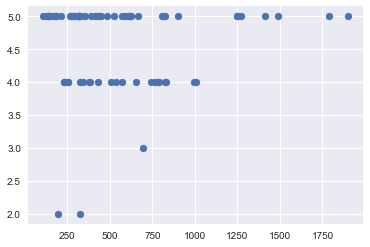

In [82]:
plt.scatter(x = 'length', y= 'stars', data=us_loc)

(array([ 2.,  1., 21., 48.]),
 array([2.  , 2.75, 3.5 , 4.25, 5.  ]),
 <BarContainer object of 4 artists>)

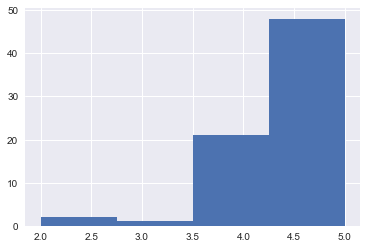

In [83]:
plt.hist(x=us_loc.stars, bins = 4)

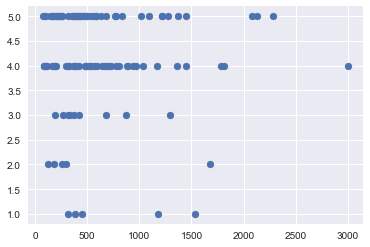

In [84]:
plt.scatter(x = 'length', y= 'stars', data=aus_loc)

(array([ 0.,  5.,  5.,  9., 41., 47.,  0.]),
 array([0.5, 1. , 2. , 3. , 4. , 5. , 6. , 6.5]),
 <BarContainer object of 7 artists>)

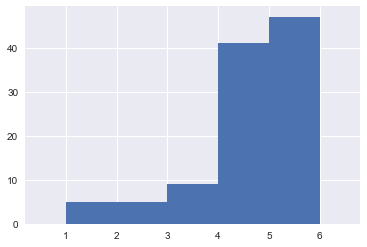

In [85]:
plt.hist(x=aus_loc.stars, bins = [0.5,1,2,3,4,5,6,6.5],)

In [87]:
print('US mean star rating: ', us_loc.stars.mean())
print('Aus mean star rating: ', aus_loc.stars.mean())
print('Overall mean star rating: ', df.stars.mean())

US mean star rating:  4.597222222222222
Aus mean star rating:  4.121495327102804
Overall mean star rating:  4.304761904761905


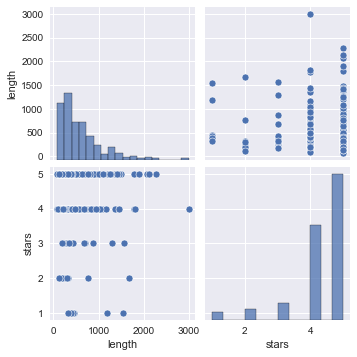

In [88]:
sns.pairplot(data=df)

# Pre-Processing the Reviews for NLP / Sentiment Analysis

In [93]:
df['length'] = df['reviews'].apply(lambda x: len(x.split()))

In [94]:
df.head()

,name,date,location,reviews,length,stars
0,Saif A.,2019-02-13,"Vancouver, Canada",The taste was amazing and the bun was spectacu...,16,5
1,Katerina K.,2020-01-20,"Foster City, CA",Cute place for breakfast or brunch.Note 1: th...,76,4
2,David L.,2019-10-29,"Garden Grove, CA",We came here at about 11:30am on Wednesday and...,130,3
3,Leah M.,2018-12-28,"Los Angeles, CA",Quite possibly the best breakfast I've ever ha...,111,5
4,Zeny M.,2019-06-20,"Markham, Canada",Walked 25 minutes to have breakfast here and g...,103,5


In [95]:
df['char_count'] = df['reviews'].apply(lambda x: len(x))

In [96]:
df.head()

,name,date,location,reviews,length,stars,char_count
0,Saif A.,2019-02-13,"Vancouver, Canada",The taste was amazing and the bun was spectacu...,16,5,97
1,Katerina K.,2020-01-20,"Foster City, CA",Cute place for breakfast or brunch.Note 1: th...,76,4,430
2,David L.,2019-10-29,"Garden Grove, CA",We came here at about 11:30am on Wednesday and...,130,3,692
3,Leah M.,2018-12-28,"Los Angeles, CA",Quite possibly the best breakfast I've ever ha...,111,5,591
4,Zeny M.,2019-06-20,"Markham, Canada",Walked 25 minutes to have breakfast here and g...,103,5,582


In [97]:
def avg_word_length(x):
    words = x.split()
    return sum(len(word) for word in words) / len(words)

In [98]:
df['avg_word_length'] = df.reviews.apply(lambda x: avg_word_length(x))

In [99]:
df.length.mean()

107.81428571428572

In [101]:
df.head()

,name,date,location,reviews,length,stars,char_count,avg_word_length
0,Saif A.,2019-02-13,"Vancouver, Canada",The taste was amazing and the bun was spectacu...,16,5,97,5.125000
1,Katerina K.,2020-01-20,"Foster City, CA",Cute place for breakfast or brunch.Note 1: th...,76,4,430,4.618421
2,David L.,2019-10-29,"Garden Grove, CA",We came here at about 11:30am on Wednesday and...,130,3,692,4.330769
3,Leah M.,2018-12-28,"Los Angeles, CA",Quite possibly the best breakfast I've ever ha...,111,5,591,4.333333
4,Zeny M.,2019-06-20,"Markham, Canada",Walked 25 minutes to have breakfast here and g...,103,5,582,4.640777


In [102]:
df.avg_word_length.mean()

4.555620604583373

In [103]:
stop_words = stopwords.words('english')

In [104]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [105]:
df['stop_word_count'] = df['reviews'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))

In [106]:
df['stop_word_rate'] = df['stop_word_count'] / df['length']

In [107]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,210.0,107.814286,85.386141,13.000000,48.750000,78.000000,141.750000,556.000000
stars,210.0,4.304762,0.954704,1.000000,4.000000,5.000000,5.000000,5.000000
char_count,210.0,593.971429,469.257552,78.000000,271.250000,433.500000,779.000000,2999.000000
avg_word_length,210.0,4.555621,0.339765,3.714286,4.310268,4.502427,4.758211,6.038462
stop_word_count,210.0,49.714286,41.171299,4.000000,21.000000,37.500000,65.500000,276.000000
stop_word_rate,210.0,0.446845,0.063602,0.250000,0.417948,0.455571,0.490631,0.562500


In [108]:
df['reviews_lower'] = df['reviews'].apply(lambda x: " ".join(word.lower() for word in x.split()))

In [109]:
df['punc_cleaned'] = df['reviews_lower'].str.replace('[^\w\s]', '')

In [110]:
df['stop_word_reviews'] = df['punc_cleaned'].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

In [111]:
pd.Series((df['stop_word_reviews']))

0      taste amazing bun spectaculari definitely comi...
1      cute place breakfast brunchnote 1 corner table...
2      came 1130am wednesday quickly seated place rec...
3      quite possibly best breakfast ive ever city me...
4      walked 25 minutes breakfast got long line took...
5      im giving place full score due restaurant pres...
6      original location branch paris come know enjoy...
7      fact manager irish way influenced positive vie...
8      place rated best brunch place many tourist gui...
9      always love good cup coffee usual baked eggs c...
10     amazing place breakfast bircher flat white unb...
11     place really busy theres long community table ...
12     great place literally pick anything menu cant ...
13     amazing restaurant brunch popular restaurant e...
14     ive heard many things hardware society became ...
15     theres lot hype place good reason ive never or...
16     decor food presentation gorgeous service excel...
17     breakfastbrunch doesnt m

# Lemmatize

In [112]:
df['lemmatize'] = df['stop_word_reviews'].apply(lambda x: " ".join(Word(word).lemmatize() for word in x.split()))

In [113]:
df.head()

,name,date,location,reviews,length,stars,char_count,avg_word_length,stop_word_count,stop_word_rate,reviews_lower,punc_cleaned,stop_word_reviews,lemmatize
0,Saif A.,2019-02-13,"Vancouver, Canada",The taste was amazing and the bun was spectacu...,16,5,97,5.125000,7,0.437500,the taste was amazing and the bun was spectacu...,the taste was amazing and the bun was spectacu...,taste amazing bun spectaculari definitely comi...,taste amazing bun spectaculari definitely comi...
1,Katerina K.,2020-01-20,"Foster City, CA",Cute place for breakfast or brunch.Note 1: th...,76,4,430,4.618421,26,0.342105,cute place for breakfast or brunch.note 1: the...,cute place for breakfast or brunchnote 1 the c...,cute place breakfast brunchnote 1 corner table...,cute place breakfast brunchnote 1 corner table...
2,David L.,2019-10-29,"Garden Grove, CA",We came here at about 11:30am on Wednesday and...,130,3,692,4.330769,59,0.453846,we came here at about 11:30am on wednesday and...,we came here at about 1130am on wednesday and ...,came 1130am wednesday quickly seated place rec...,came 1130am wednesday quickly seated place rec...
3,Leah M.,2018-12-28,"Los Angeles, CA",Quite possibly the best breakfast I've ever ha...,111,5,591,4.333333,53,0.477477,quite possibly the best breakfast i've ever ha...,quite possibly the best breakfast ive ever had...,quite possibly best breakfast ive ever city me...,quite possibly best breakfast ive ever city me...
4,Zeny M.,2019-06-20,"Markham, Canada",Walked 25 minutes to have breakfast here and g...,103,5,582,4.640777,45,0.436893,walked 25 minutes to have breakfast here and g...,walked 25 minutes to have breakfast here and g...,walked 25 minutes breakfast got long line took...,walked 25 minute breakfast got long line took ...


# Sentiment Analysis

In [114]:
df['polarity'] = df['lemmatize'].apply(lambda x: TextBlob(x).sentiment[0])

In [115]:
df['subjectivity'] = df['lemmatize'].apply(lambda x: TextBlob(x).sentiment[1])

In [116]:
df.head()

,name,date,location,reviews,length,stars,char_count,avg_word_length,stop_word_count,stop_word_rate,reviews_lower,punc_cleaned,stop_word_reviews,lemmatize,polarity,subjectivity
0,Saif A.,2019-02-13,"Vancouver, Canada",The taste was amazing and the bun was spectacu...,16,5,97,5.125000,7,0.437500,the taste was amazing and the bun was spectacu...,the taste was amazing and the bun was spectacu...,taste amazing bun spectaculari definitely comi...,taste amazing bun spectaculari definitely comi...,0.300000,0.700000
1,Katerina K.,2020-01-20,"Foster City, CA",Cute place for breakfast or brunch.Note 1: th...,76,4,430,4.618421,26,0.342105,cute place for breakfast or brunch.note 1: the...,cute place for breakfast or brunchnote 1 the c...,cute place breakfast brunchnote 1 corner table...,cute place breakfast brunchnote 1 corner table...,0.409864,0.639229
2,David L.,2019-10-29,"Garden Grove, CA",We came here at about 11:30am on Wednesday and...,130,3,692,4.330769,59,0.453846,we came here at about 11:30am on wednesday and...,we came here at about 1130am on wednesday and ...,came 1130am wednesday quickly seated place rec...,came 1130am wednesday quickly seated place rec...,0.225870,0.445238
3,Leah M.,2018-12-28,"Los Angeles, CA",Quite possibly the best breakfast I've ever ha...,111,5,591,4.333333,53,0.477477,quite possibly the best breakfast i've ever ha...,quite possibly the best breakfast ive ever had...,quite possibly best breakfast ive ever city me...,quite possibly best breakfast ive ever city me...,0.294470,0.458687
4,Zeny M.,2019-06-20,"Markham, Canada",Walked 25 minutes to have breakfast here and g...,103,5,582,4.640777,45,0.436893,walked 25 minutes to have breakfast here and g...,walked 25 minutes to have breakfast here and g...,walked 25 minutes breakfast got long line took...,walked 25 minute breakfast got long line took ...,0.131250,0.650000


In [117]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,210.0,107.814286,85.386141,13.000000,48.750000,78.000000,141.750000,556.000000
stars,210.0,4.304762,0.954704,1.000000,4.000000,5.000000,5.000000,5.000000
char_count,210.0,593.971429,469.257552,78.000000,271.250000,433.500000,779.000000,2999.000000
avg_word_length,210.0,4.555621,0.339765,3.714286,4.310268,4.502427,4.758211,6.038462
stop_word_count,210.0,49.714286,41.171299,4.000000,21.000000,37.500000,65.500000,276.000000
stop_word_rate,210.0,0.446845,0.063602,0.250000,0.417948,0.455571,0.490631,0.562500
polarity,210.0,0.311637,0.178268,-0.350000,0.227562,0.312202,0.418229,1.000000
subjectivity,210.0,0.580111,0.126705,0.150000,0.500521,0.577844,0.652798,1.000000


Text(0.5, 1.0, 'Review Polarity vs. Subjectivity')

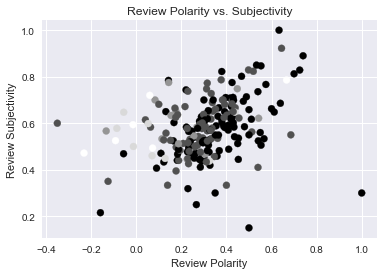

In [118]:
plt.scatter(x=df.polarity, y=df.subjectivity, c=df.stars)
plt.xlabel('Review Polarity')
plt.ylabel('Review Subjectivity')
plt.title('Review Polarity vs. Subjectivity')

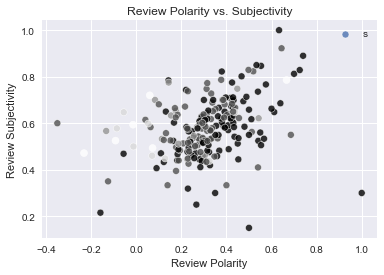

In [119]:
sns.scatterplot(x=df.polarity, y=df.subjectivity, c=df.stars, alpha = 0.8)
plt.xlabel('Review Polarity')
plt.ylabel('Review Subjectivity')
plt.title('Review Polarity vs. Subjectivity')
plt.legend('stars')

Text(0.5, 1.0, 'Review Polarity vs. Stars')

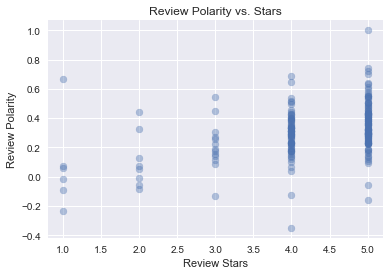

In [120]:
plt.scatter(y=df.polarity, x=df.stars, alpha=0.4)
plt.ylabel('Review Polarity')
plt.xlabel('Review Stars')
plt.title('Review Polarity vs. Stars')

#fig = plt.gcf()
#fig.savefig('Review Stars vs. Polarity.png')

Text(0.5, 1.0, 'Review Polarity vs. Stars')

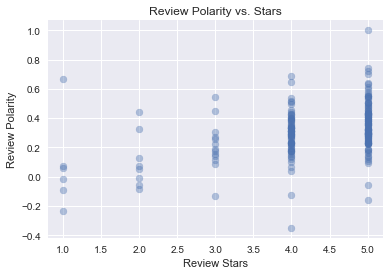

In [121]:
plt.scatter(y=df.polarity, x=df.stars, alpha=0.4)
plt.ylabel('Review Polarity')
plt.xlabel('Review Stars')
plt.title('Review Polarity vs. Stars')

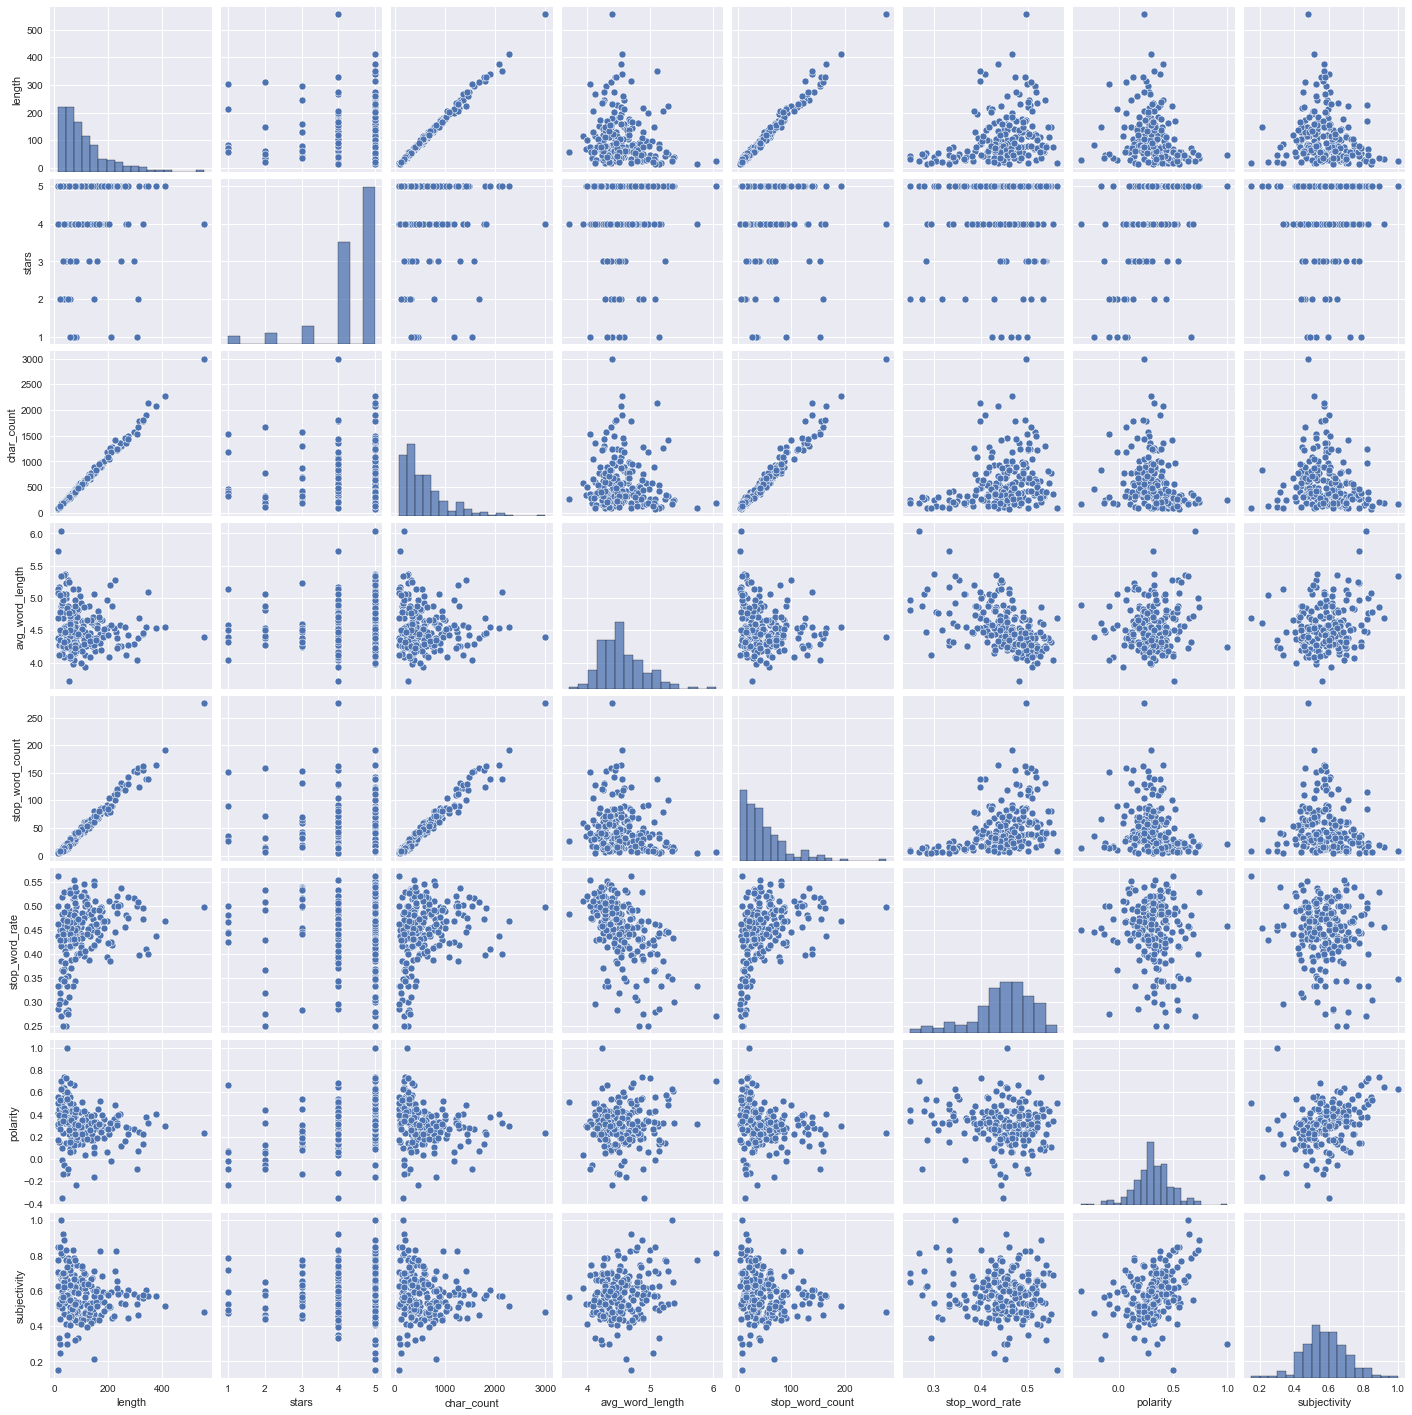

In [122]:
sns.pairplot(data=df)

In [123]:
print('Polarity maximum value: ', df.polarity.max(),
      '\nPolarity minimum value: ', df.polarity.min(),
      '\nPolarity average value: ', df.polarity.mean())

Polarity maximum value:  1.0 
Polarity minimum value:  -0.35 
Polarity average value:  0.3116374937955483


Text(0.5, 1.0, 'Review Polarity vs. Subjectivity')

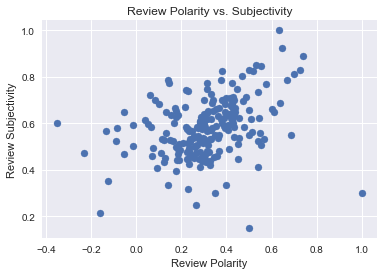

In [124]:
plt.scatter(x=df.polarity, y=df.subjectivity)
plt.xlabel('Review Polarity')
plt.ylabel('Review Subjectivity')
plt.title('Review Polarity vs. Subjectivity')

In [126]:
# Reading the most negative review by polarity
df.loc[df.polarity == -0.35]

,name,date,location,reviews,length,stars,char_count,avg_word_length,stop_word_count,stop_word_rate,reviews_lower,punc_cleaned,stop_word_reviews,lemmatize,polarity,subjectivity
135,Ghen L.,2015-12-04,"Newton, Singapore, Singapore",I'm addicted to the Baked eggs with Chorizos. ...,29,4,170,4.896552,13,0.448276,i'm addicted to the baked eggs with chorizos. ...,im addicted to the baked eggs with chorizos on...,im addicted baked eggs chorizos one busiest br...,im addicted baked egg chorizo one busiest brea...,-0.35,0.6


In [127]:
df.reviews[135]

"I'm addicted to the Baked eggs with Chorizos. One of the busiest breakfast/brunch places in Melbourne. Be prepared to queue up for 30-40 minutes If you're a late starter."

# Modelling

In [75]:
#data_classes = df[(df['stars']==1) | (df['stars']==3) | (df['stars']==5)]
#data_classes.head()
#print(data_classes.shape)

# Separate the dataset into X and Y for prediction
#x = data_classes['reviews']
#y = data_classes['stars']


y = df['stars']
print(X.head())
print(y.head())

0    taste amazing bun spectaculari definitely comi...
1    cute place breakfast brunchnote 1 corner table...
2    came 1130am wednesday quickly seated place rec...
3    quite possibly best breakfast ive ever city me...
4    walked 25 minutes breakfast got long line took...
Name: stop_word_reviews, dtype: object
0    5
1    4
2    3
3    5
4    5
Name: stars, dtype: int64


In [95]:
x = df['reviews']

In [96]:
x

0      The taste was amazing and the bun was spectacu...
1      Cute place  for breakfast or brunch.Note 1: th...
2      We came here at about 11:30am on Wednesday and...
3      Quite possibly the best breakfast I've ever ha...
4      Walked 25 minutes to have breakfast here and g...
5      I'm giving this place a full score due to both...
6      This is the original location of the branch in...
7      The fact that the manager was Irish in no way ...
8      This place is rated as the best brunch place o...
9      Always love a good cup of coffee, with my usua...
10     An amazing place for breakfast!  I had the bir...
11     This place is really busy.  There's a long, co...
12     Great place! You literally can pick anything o...
13     This is an amazing restaurant for brunch! It's...
14     I've heard so many things about Hardware Socie...
15     There's a lot of hype for this place but with ...
16     The decor and food presentation is gorgeous an...
17     Breakfast/Brunch - doesn

In [97]:
def text_process(reviews):
    nopunc = [char for char in reviews if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [99]:
x

0      The taste was amazing and the bun was spectacu...
1      Cute place  for breakfast or brunch.Note 1: th...
2      We came here at about 11:30am on Wednesday and...
3      Quite possibly the best breakfast I've ever ha...
4      Walked 25 minutes to have breakfast here and g...
5      I'm giving this place a full score due to both...
6      This is the original location of the branch in...
7      The fact that the manager was Irish in no way ...
8      This place is rated as the best brunch place o...
9      Always love a good cup of coffee, with my usua...
10     An amazing place for breakfast!  I had the bir...
11     This place is really busy.  There's a long, co...
12     Great place! You literally can pick anything o...
13     This is an amazing restaurant for brunch! It's...
14     I've heard so many things about Hardware Socie...
15     There's a lot of hype for this place but with ...
16     The decor and food presentation is gorgeous an...
17     Breakfast/Brunch - doesn

# Vectorizing

In [128]:
vocab = CountVectorizer().fit(X)
print(len(vocab.vocabulary_))
r0 = X[0]
print(r0)
vocab0 = vocab.transform([r0])
print(vocab0, '\n')
print("Getting the words back:")
print(vocab.get_feature_names()[2214])
print(vocab.get_feature_names()[745])

NameError: name 'X' is not defined

In [123]:
X

0      taste amazing bun spectaculari definitely comi...
1      cute place breakfast brunchnote 1 corner table...
2      came 1130am wednesday quickly seated place rec...
3      quite possibly best breakfast ive ever city me...
4      walked 25 minutes breakfast got long line took...
5      im giving place full score due restaurant pres...
6      original location branch paris come know enjoy...
7      fact manager irish way influenced positive vie...
8      place rated best brunch place many tourist gui...
9      always love good cup coffee usual baked eggs c...
10     amazing place breakfast bircher flat white unb...
11     place really busy theres long community table ...
12     great place literally pick anything menu cant ...
13     amazing restaurant brunch popular restaurant e...
14     ive heard many things hardware society became ...
15     theres lot hype place good reason ive never or...
16     decor food presentation gorgeous service excel...
17     breakfastbrunch doesnt m

In [383]:
vocab1 = CountVectorizer(analyzer=text_process).fit(x)
print(len(vocab.vocabulary_))
r2 = x[2]
print(r2)
vocab2 = vocab1.transform([r2])
print(vocab2, '\n')
print("Getting the words back:")
print(vocab1.get_feature_names()[2214])
print(vocab1.get_feature_names()[745])

3097
came 1130am wednesday quickly seated place recommended several people hip vibe decor mirrored vibe ordered lobster benedict iced latte green tea latte lobster benedict flavors went well bun dipped oozing egg yolk delicious feel like little short lobster since forgot lobster benedict bite lobster eating almost half itgreen tea latte drink good foam really tasted like matcha latte semi sweet iced latte nothing special average iced latte good
  (0, 8)	1
  (0, 99)	1
  (0, 165)	1
  (0, 214)	3
  (0, 233)	1
  (0, 287)	1
  (0, 311)	1
  (0, 547)	1
  (0, 555)	1
  (0, 595)	1
  (0, 634)	1
  (0, 662)	1
  (0, 671)	1
  (0, 782)	1
  (0, 811)	1
  (0, 820)	1
  (0, 832)	1
  (0, 905)	2
  (0, 919)	1
  (0, 933)	1
  (0, 978)	1
  (0, 1023)	3
  (0, 1083)	1
  (0, 1138)	6
  (0, 1157)	2
  :	:
  (0, 1179)	5
  (0, 1240)	1
  (0, 1292)	1
  (0, 1371)	1
  (0, 1403)	1
  (0, 1418)	1
  (0, 1476)	1
  (0, 1509)	1
  (0, 1596)	1
  (0, 1623)	1
  (0, 1635)	1
  (0, 1738)	1
  (0, 1754)	1
  (0, 1773)	1
  (0, 1784)	1
  (0, 180

In [102]:
x

0      The taste was amazing and the bun was spectacu...
1      Cute place  for breakfast or brunch.Note 1: th...
2      We came here at about 11:30am on Wednesday and...
3      Quite possibly the best breakfast I've ever ha...
4      Walked 25 minutes to have breakfast here and g...
5      I'm giving this place a full score due to both...
6      This is the original location of the branch in...
7      The fact that the manager was Irish in no way ...
8      This place is rated as the best brunch place o...
9      Always love a good cup of coffee, with my usua...
10     An amazing place for breakfast!  I had the bir...
11     This place is really busy.  There's a long, co...
12     Great place! You literally can pick anything o...
13     This is an amazing restaurant for brunch! It's...
14     I've heard so many things about Hardware Socie...
15     There's a lot of hype for this place but with ...
16     The decor and food presentation is gorgeous an...
17     Breakfast/Brunch - doesn

In [131]:
x = vocab.transform(x)
#Shape of the matrix:
print("Shape of the sparse matrix: ", x.shape)
#Non-zero occurences:
print("Non-Zero occurences: ",x.nnz)

# DENSITY OF THE MATRIX
density = (x.nnz/(x.shape[0]*x.shape[1]))*100
print("Density of the matrix = ",density)

Shape of the sparse matrix:  (210, 3097)
Non-Zero occurences:  10236
Density of the matrix =  1.5738733336408506


In [83]:
len(np.sum(df.stop_word_reviews))

80909

In [132]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [133]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(x_train,y_train)
predmnb = mnb.predict(x_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))

Confusion Matrix for Multinomial Naive Bayes:
[[ 0  0  2]
 [ 0  5 13]
 [ 0  2 20]]
Score: 59.52
Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           4       0.71      0.28      0.40        18
           5       0.57      0.91      0.70        22

    accuracy                           0.60        42
   macro avg       0.43      0.40      0.37        42
weighted avg       0.61      0.60      0.54        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [134]:
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(x_train,y_train)
predrmfr = rmfr.predict(x_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Score:",round(accuracy_score(y_test,predrmfr)*100,2))
print("Classification Report:",classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[ 0  0  2]
 [ 0  2 16]
 [ 0  0 22]]
Score: 57.14
Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           4       1.00      0.11      0.20        18
           5       0.55      1.00      0.71        22

    accuracy                           0.57        42
   macro avg       0.52      0.37      0.30        42
weighted avg       0.72      0.57      0.46        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [136]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
preddt = dt.predict(x_test)
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test,preddt))
print("Score:",round(accuracy_score(y_test,preddt)*100,2))
print("Classification Report:",classification_report(y_test,preddt))

Confusion Matrix for Decision Tree:
[[ 0  0  2  0]
 [ 0  0  0  0]
 [ 0  0  7 11]
 [ 0  2  4 16]]
Score: 54.76
Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.54      0.39      0.45        18
           5       0.59      0.73      0.65        22

    accuracy                           0.55        42
   macro avg       0.28      0.28      0.28        42
weighted avg       0.54      0.55      0.54        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\

In [137]:
df.tail()

,name,date,location,star_ratings,reviews,length,stars,char_count,avg_word_length,stop_word_count,stop_word_rate,reviews_lower,punc_cleaned,stop_word_reviews,lemmatize,polarity,subjectivity
205,Emilie P.,7/07/2016,"Ville de Québec, Canada",5 star rating,"Wow wow wow! Best brekky ever! Cute place, kin...",32,5,190,4.968750,8,0.250000,"wow wow wow! best brekky ever! cute place, kin...",wow wow wow best brekky ever cute place kind p...,wow wow wow best brekky ever cute place kind p...,wow wow wow best brekky ever cute place kind p...,0.341250,0.700000
206,Alex F.,4/12/2016,"Seattle, WA",5 star rating,Eclectic mix of French and Mexican inspired br...,21,5,126,5.047619,9,0.428571,eclectic mix of french and mexican inspired br...,eclectic mix of french and mexican inspired br...,eclectic mix french mexican inspired brunch hi...,eclectic mix french mexican inspired brunch hi...,0.266667,0.250000
207,Kathryn B.,6/11/2013,"San Francisco, CA",5 star rating,I thought I was eating some good food in Melbo...,231,5,1250,4.385281,112,0.484848,i thought i was eating some good food in melbo...,i thought i was eating some good food in melbo...,thought eating good food melbourne came first ...,thought eating good food melbourne came first ...,0.305508,0.614078
208,Allan B.,10/16/2011,"Windermere, FL",4 star rating,"Well Hardware Lane is an interesting place, to...",154,4,825,4.357143,71,0.461039,"well hardware lane is an interesting place, to...",well hardware lane is an interesting place to ...,well hardware lane interesting place sure tiny...,well hardware lane interesting place sure tiny...,0.293137,0.601307
209,Olivia H.,5/08/2013,"Melbourne, Australia",4 star rating,Hardware society was a hit and miss. Maybe I h...,165,4,941,4.703030,81,0.490909,hardware society was a hit and miss. maybe i h...,hardware society was a hit and miss maybe i ha...,hardware society hit miss maybe high expectati...,hardware society hit miss maybe high expectati...,0.311036,0.433786


In [88]:
# Support Vector Machine
from sklearn.svm import SVC
svm = SVC(random_state=101)
svm.fit(x_train,y_train)
predsvm = svm.predict(x_test)
print("Confusion Matrix for Support Vector Machines:")
print(confusion_matrix(y_test,predsvm))
print("Score:",round(accuracy_score(y_test,predsvm)*100,2))
print("Classification Report:",classification_report(y_test,predsvm))

Confusion Matrix for Support Vector Machines:
[[ 0  0  3]
 [ 0  0 14]
 [ 0  1 24]]
Score: 57.14
Classification Report:               precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        14
           5       0.59      0.96      0.73        25

    accuracy                           0.57        42
   macro avg       0.20      0.32      0.24        42
weighted avg       0.35      0.57      0.43        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [140]:
# K Nearest Neighbour Algorithm
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train,y_train)
predknn = knn.predict(x_test)
print("Confusion Matrix for K Neighbors Classifier:")
print(confusion_matrix(y_test,predknn))
print("Score: ",round(accuracy_score(y_test,predknn)*100,2))
print("Classification Report:")
print(classification_report(y_test,predknn))

Confusion Matrix for K Neighbors Classifier:
[[ 0  0  2]
 [ 0  0 18]
 [ 0  3 19]]
Score:  45.24
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        18
           5       0.49      0.86      0.62        22

    accuracy                           0.45        42
   macro avg       0.16      0.29      0.21        42
weighted avg       0.26      0.45      0.33        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [141]:
# XGBoost Classifier
import xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train,y_train)
predxgb = xgb.predict(x_test)
print("Confusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_test,predxgb))
print("Score: ",round(accuracy_score(y_test,predxgb)*100,2))
print("Classification Report:")
print(classification_report(y_test,predxgb))

C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:07:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for XGBoost Classifier:
[[ 0  0  2]
 [ 0  7 11]
 [ 0  4 18]]
Score:  59.52
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           4       0.64      0.39      0.48        18
           5       0.58      0.82      0.68        22

    accuracy                           0.60        42
   macro avg       0.41      0.40      0.39        42
weighted avg       0.58      0.60      0.56        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [142]:
# MULTILAYER PERCEPTRON CLASSIFIER
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train,y_train)
predmlp = mlp.predict(x_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
print("Score:",round(accuracy_score(y_test,predmlp)*100,2))
print("Classification Report:")
print(classification_report(y_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[ 0  0  2]
 [ 0  7 11]
 [ 0  3 19]]
Score: 61.9
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           4       0.70      0.39      0.50        18
           5       0.59      0.86      0.70        22

    accuracy                           0.62        42
   macro avg       0.43      0.42      0.40        42
weighted avg       0.61      0.62      0.58        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [92]:
# POSITIVE REVIEW
pr = df['reviews'][0]
print(pr)
print("Actual Rating: ",df['stars'][0])
pr_t = vocab.transform([pr])
print("Predicted Rating:")
mlp.predict(pr_t)[0]

The taste was amazing and the bun was spectacular.I am definitely coming back.Last call is 2:30pm
Actual Rating:  5
Predicted Rating:


5

In [93]:
# AVERAGE REVIEW
ar = df['reviews'][16]
print(ar)
print("Actual Rating: ",df['stars'][16])
ar_t = vocab.transform([ar])
print("Predicted Rating:")
mlp.predict(ar_t)[0]

The decor and food presentation is gorgeous and service is excellent but none of us loved our meals and it was expensive. My husband did not enjoy the vegetarian baked eggs. He felt it tasted bland. My daughter did not love her eggs with smoked salmon.  It looked a lot better than it tasted. I had the Bircher which was tasty but much too sweet for a meal. It would have been delicious if it was for dessert.
Actual Rating:  3
Predicted Rating:


3

In [94]:
nr = df['reviews'][55]
print(nr)
print("Actual Rating: ",df['stars'][55])
nr_t = vocab.transform([nr])
print("Predicted Rating:")
mlp.predict(nr_t)[0]

Terrible terrible service. I know they are famous. But they can not be that rude service. And they let us seat next rubbish bin. And they said you guys should be alright?   And. Explanation was very poor.   We were asking and considering about menu. Maybe few second    She didnt excuse us. Just said i will give you few min for you guys.    ? What ?   We about order    Morning busy hour.  And. They served half eaten butter   With someones bread pieces
Actual Rating:  1
Predicted Rating:


1

In [ ]:
df_low = pd.DataFrame(df.loc[(df.stars ==  1) | (df.stars == 2)])
df_low

In [ ]:
sns.lmplot(y='stars', x='polarity', data=df_low)
plt.title('Stars vs. Review Polarity')
plt.ylabel('Review Stars')
plt.xlabel('Polarity of Review')

In [ ]:
df_mid = pd.DataFrame(df.loc[(df.stars ==  3)])
df_mid

In [ ]:
sns.lmplot(y='stars', x='polarity', data=df_mid)
plt.title('Stars vs. Review Polarity')
plt.ylabel('Review Stars')
plt.xlabel('Polarity of Review')

In [ ]:
df_high = pd.DataFrame(df.loc[(df.stars ==  4) | (df.stars == 5)])
df_high

In [ ]:
sns.lmplot(y='stars', x='polarity', data=df_high)
plt.title('Stars vs. Review Polarity')
plt.ylabel('Review Stars')
plt.xlabel('Polarity of Review')

In [ ]:
df.stars.value_counts()

In [ ]:
sns.lmplot(x='stars', y='polarity', data=df)
plt.title('Stars vs. Review Polarity')
plt.xlabel('Review Stars')
plt.ylabel('Polarity of Review')

In [113]:
neg_revs = df.loc[df.polarity < 0]

In [115]:
neg_revs.mean()

length              91.545455
stars                2.727273
char_count         496.636364
avg_word_length      4.552066
stop_word_count     41.181818
stop_word_rate       0.431951
polarity            -0.119605
subjectivity         0.501472
dtype: float64

In [120]:
neutral_revs = df.loc[(df.polarity > 0) & (df.polarity < 0.4)]

In [121]:
neutral_revs.mean()

length             125.428571
stars                4.307143
char_count         688.757143
avg_word_length      4.529063
stop_word_count     58.300000
stop_word_rate       0.451972
polarity             0.261324
subjectivity         0.556599
dtype: float64

In [122]:
df.corr()

,length,stars,char_count,avg_word_length,stop_word_count,stop_word_rate,polarity,subjectivity
length,1.000000,-0.032171,0.997010,-0.167037,0.990167,0.284561,-0.195447,-0.149375
stars,-0.032171,1.000000,-0.018873,0.098701,-0.043909,0.004732,0.409243,-0.015706
char_count,0.997010,-0.018873,1.000000,-0.111266,0.980455,0.255575,-0.187735,-0.142367
avg_word_length,-0.167037,0.098701,-0.111266,1.000000,-0.223345,-0.527524,0.092032,0.218936
stop_word_count,0.990167,-0.043909,0.980455,-0.223345,1.000000,0.376865,-0.201868,-0.148819
stop_word_rate,0.284561,0.004732,0.255575,-0.527524,0.376865,1.000000,-0.111803,-0.110881
polarity,-0.195447,0.409243,-0.187735,0.092032,-0.201868,-0.111803,1.000000,0.340719
subjectivity,-0.149375,-0.015706,-0.142367,0.218936,-0.148819,-0.110881,0.340719,1.000000


In [ ]:
plt.hist()

In [553]:
X = df.lemmatize

In [554]:
vocab = CountVectorizer().fit(X)
print(len(vocab.vocabulary_))
r0 = X[0]
print(r0)
vocab0 = vocab.transform([r0])
print(vocab0, '\n')
print("Getting the words back:")
print(vocab.get_feature_names()[2214])
print(vocab.get_feature_names()[745])

2872
taste amazing bun spectaculari definitely coming backlast call 230pm
  (0, 28)	1
  (0, 136)	1
  (0, 238)	1
  (0, 378)	1
  (0, 410)	1
  (0, 534)	1
  (0, 709)	1
  (0, 2377)	1
  (0, 2525)	1 

Getting the words back:
seasonal
didnt


In [555]:
X = vocab.transform(X)
#Shape of the matrix:
print("Shape of the sparse matrix: ", X.shape)
#Non-zero occurences:
print("Non-Zero occurences: ",X.nnz)

# DENSITY OF THE MATRIX
density = (X.nnz/(X.shape[0]*X.shape[1]))*100
print("Density of the matrix = ",density)

Shape of the sparse matrix:  (210, 2872)
Non-Zero occurences:  10382
Density of the matrix =  1.7213821461732326


In [556]:
# SPLITTING THE DATASET INTO TRAINING SET AND TESTING SET
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [557]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
predmnb = mnb.predict(X_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))

Confusion Matrix for Multinomial Naive Bayes:
[[ 1  0  1]
 [ 1  0  3]
 [ 0  0 36]]
Score: 88.1
Classification Report:               precision    recall  f1-score   support

           1       0.50      0.50      0.50         2
           2       0.00      0.00      0.00         4
           3       0.90      1.00      0.95        36

    accuracy                           0.88        42
   macro avg       0.47      0.50      0.48        42
weighted avg       0.80      0.88      0.84        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [558]:
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(X_train,y_train)
predrmfr = rmfr.predict(X_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Score:",round(accuracy_score(y_test,predrmfr)*100,2))
print("Classification Report:",classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[ 0  0  2]
 [ 0  0  4]
 [ 0  0 36]]
Score: 85.71
Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         4
           3       0.86      1.00      0.92        36

    accuracy                           0.86        42
   macro avg       0.29      0.33      0.31        42
weighted avg       0.73      0.86      0.79        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [559]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
preddt = dt.predict(X_test)
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test,preddt))
print("Score:",round(accuracy_score(y_test,preddt)*100,2))
print("Classification Report:",classification_report(y_test,preddt))

Confusion Matrix for Decision Tree:
[[ 1  0  1]
 [ 0  1  3]
 [ 2  0 34]]
Score: 85.71
Classification Report:               precision    recall  f1-score   support

           1       0.33      0.50      0.40         2
           2       1.00      0.25      0.40         4
           3       0.89      0.94      0.92        36

    accuracy                           0.86        42
   macro avg       0.74      0.56      0.57        42
weighted avg       0.88      0.86      0.84        42



In [560]:
# Support Vector Machine
from sklearn.svm import SVC
svm = SVC(random_state=101)
svm.fit(X_train,y_train)
predsvm = svm.predict(X_test)
print("Confusion Matrix for Support Vector Machines:")
print(confusion_matrix(y_test,predsvm))
print("Score:",round(accuracy_score(y_test,predsvm)*100,2))
print("Classification Report:",classification_report(y_test,predsvm))

Confusion Matrix for Support Vector Machines:
[[ 0  0  2]
 [ 0  0  4]
 [ 0  0 36]]
Score: 85.71
Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         4
           3       0.86      1.00      0.92        36

    accuracy                           0.86        42
   macro avg       0.29      0.33      0.31        42
weighted avg       0.73      0.86      0.79        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [561]:
# K Nearest Neighbour Algorithm
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
predknn = knn.predict(X_test)
print("Confusion Matrix for K Neighbors Classifier:")
print(confusion_matrix(y_test,predknn))
print("Score: ",round(accuracy_score(y_test,predknn)*100,2))
print("Classification Report:")
print(classification_report(y_test,predknn))

Confusion Matrix for K Neighbors Classifier:
[[ 0  0  2]
 [ 0  0  4]
 [ 0  0 36]]
Score:  85.71
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         4
           3       0.86      1.00      0.92        36

    accuracy                           0.86        42
   macro avg       0.29      0.33      0.31        42
weighted avg       0.73      0.86      0.79        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [562]:
# XGBoost Classifier
import xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train,y_train)
predxgb = xgb.predict(x_test)
print("Confusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_test,predxgb))
print("Score: ",round(accuracy_score(y_test,predxgb)*100,2))
print("Classification Report:")
print(classification_report(y_test,predxgb))

C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:38:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for XGBoost Classifier:
[[ 1  0  1]
 [ 0  0  4]
 [ 1  0 35]]
Score:  85.71
Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.50      0.50         2
           2       0.00      0.00      0.00         4
           3       0.88      0.97      0.92        36

    accuracy                           0.86        42
   macro avg       0.46      0.49      0.47        42
weighted avg       0.77      0.86      0.81        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [563]:
# MULTILAYER PERCEPTRON CLASSIFIER
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train,y_train)
predmlp = mlp.predict(x_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
print("Score:",round(accuracy_score(y_test,predmlp)*100,2))
print("Classification Report:")
print(classification_report(y_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[ 0  0  2]
 [ 0  0  4]
 [ 0  0 36]]
Score: 85.71
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         4
           3       0.86      1.00      0.92        36

    accuracy                           0.86        42
   macro avg       0.29      0.33      0.31        42
weighted avg       0.73      0.86      0.79        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

# Changing the target to classification - negative review (1&2 stars,) neutral review (3 stars,) positive review (4&5 stars)

In [129]:
star_class = []

In [130]:
type(star_class)

list

In [131]:
for (i) in range(df.shape[0]):
    if df.stars[i] <= 2:
        j = 1
    elif df.stars[i] == 3:
        j = 2
    else: 
        j = 3
        
    star_class.append(j)

In [132]:
df['star_class'] = star_class

In [133]:
df.star_class.value_counts()

3    183
1     14
2     13
Name: star_class, dtype: int64

In [462]:
df.stars.value_counts()

5    111
4     72
3     13
2      8
1      6
Name: stars, dtype: int64

# Modelling with neg/pos/neutral classification of target

In [564]:
X = df.lemmatize

In [565]:
vocab = CountVectorizer().fit(X)
print(len(vocab.vocabulary_))
r0 = X[0]
print(r0)
vocab0 = vocab.transform([r0])
print(vocab0, '\n')
print("Getting the words back:")
print(vocab.get_feature_names()[2214])
print(vocab.get_feature_names()[745])

2872
taste amazing bun spectaculari definitely coming backlast call 230pm
  (0, 28)	1
  (0, 136)	1
  (0, 238)	1
  (0, 378)	1
  (0, 410)	1
  (0, 534)	1
  (0, 709)	1
  (0, 2377)	1
  (0, 2525)	1 

Getting the words back:
seasonal
didnt


In [566]:
y = df.star_class

In [567]:
X = vocab.transform(X)
#Shape of the matrix:
print("Shape of the sparse matrix: ", X.shape)
#Non-zero occurences:
print("Non-Zero occurences: ",X.nnz)

# DENSITY OF THE MATRIX
density = (X.nnz/(X.shape[0]*X.shape[1]))*100
print("Density of the matrix = ",density)

Shape of the sparse matrix:  (210, 2872)
Non-Zero occurences:  10382
Density of the matrix =  1.7213821461732326


In [568]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [569]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train,y_train, )
predmnb = mnb.predict(X_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
mnb_score = cross_val_score(mnb, X_train, y_train, cv=5)
print("Score: ", (mnb_score.mean())*100)
print("Classification Report:",classification_report(y_test,predmnb))

Confusion Matrix for Multinomial Naive Bayes:
[[ 0  0  4]
 [ 0  0  3]
 [ 0  2 33]]
Score:  88.07486631016042
Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.82      0.94      0.88        35

    accuracy                           0.79        42
   macro avg       0.27      0.31      0.29        42
weighted avg       0.69      0.79      0.73        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [570]:
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(X_train,y_train)
predrmfr = rmfr.predict(X_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
rmfr_score = cross_val_score(rmfr, X_train, y_train, cv=5)
print("Score:", (rmfr_score.mean())*100)
print("Classification Report:",classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[ 0  0  4]
 [ 0  0  3]
 [ 0  0 35]]
Score: 88.09269162210339
Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.83      1.00      0.91        35

    accuracy                           0.83        42
   macro avg       0.28      0.33      0.30        42
weighted avg       0.69      0.83      0.76        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [571]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
preddt = dt.predict(X_test)
print("Confusion Matrix for Decision Tree:")
dt_score = cross_val_score(dt, X_train, y_train, cv=5)
print("Score:", (dt_score.mean())*100)
print("Classification Report:",classification_report(y_test,preddt))

Confusion Matrix for Decision Tree:
Score: 84.5632798573975
Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.88      1.00      0.93        35

    accuracy                           0.83        42
   macro avg       0.29      0.33      0.31        42
weighted avg       0.73      0.83      0.78        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [572]:
# Support Vector Machine
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train,y_train)
predsvm = svm.predict(X_test)
print("Confusion Matrix for Support Vector Machines:")
svm_score = cross_val_score(svm, X_train, y_train, cv=5)
print("Score:", (svm_score.mean())*100)
print("Classification Report:",classification_report(y_test,predsvm))

Confusion Matrix for Support Vector Machines:
Score: 88.09269162210339
Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.83      1.00      0.91        35

    accuracy                           0.83        42
   macro avg       0.28      0.33      0.30        42
weighted avg       0.69      0.83      0.76        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [573]:
# K Nearest Neighbour Algorithm
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
predknn = knn.predict(X_test)
print("Confusion Matrix for K Neighbors Classifier:")
print(confusion_matrix(y_test,predknn))
knn_score = cross_val_score(knn, X_train, y_train, cv=5)
print("Score:", (knn_score.mean())*100)
print("Classification Report:")
print(classification_report(y_test,predknn))

Confusion Matrix for K Neighbors Classifier:
[[ 0  0  4]
 [ 0  0  3]
 [ 0  0 35]]
Score: 88.09269162210339
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.83      1.00      0.91        35

    accuracy                           0.83        42
   macro avg       0.28      0.33      0.30        42
weighted avg       0.69      0.83      0.76        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [574]:
# XGBoost Classifier
import xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
predxgb = xgb.predict(X_test)
print("Confusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_test,predxgb))
xgb_score = cross_val_score(xgb, X_train, y_train, cv=5)
print("Score:", (xgb_score.mean())*100)
print("Classification Report:")
print(classification_report(y_test,predxgb))

C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:39:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for XGBoost Classifier:
[[ 0  0  4]
 [ 0  0  3]
 [ 0  0 35]]
[11:39:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:39:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:39:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:39:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:39:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score: 86.89839572192513
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.83      1.00      0.91        35

    accuracy                           0.83        42
   macro avg       0.28      0.33      0.30        42
weighted avg       0.69      0.83      0.76        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [575]:
# MULTILAYER PERCEPTRON CLASSIFIER
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train,y_train)
predmlp = mlp.predict(X_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
mlp_score = cross_val_score(mlp, X_train, y_train, cv=5)
print("Score:", (mlp_score.mean())*100)
print("Classification Report:")
print(classification_report(y_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[ 0  0  4]
 [ 0  0  3]
 [ 0  1 34]]
Score: 88.09269162210339
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.83      0.97      0.89        35

    accuracy                           0.81        42
   macro avg       0.28      0.32      0.30        42
weighted avg       0.69      0.81      0.75        42



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [475]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_test))

Counter({3: 147, 1: 12, 2: 9})
Counter({3: 36, 2: 4, 1: 2})


# Producing a summary of scores

In [576]:
cv_score_dict = {'Multinomial Naive Bayes': mnb_score.mean(), 'Random Forest': rmfr_score.mean(), 'Decision Trees': dt_score.mean(), 'Support Vector Machines': svm_score.mean(), 'K-Nearest Neighbors': knn_score.mean(), 'XGBoost': xgb_score.mean(), 'Multilayer Perceptron Classifier': mlp_score.mean()}

In [577]:
df_cvscore = pd.DataFrame.from_dict(data=cv_score_dict, orient='index')
df_cvscore

,0
Multinomial Naive Bayes,0.880749
Random Forest,0.880927
Decision Trees,0.845633
Support Vector Machines,0.880927
K-Nearest Neighbors,0.880927
XGBoost,0.868984
Multilayer Perceptron Classifier,0.880927


# Producing ROC_AUC score

In [578]:
mnb_rocauc = roc_auc_score(y, mnb.predict_proba(X), multi_class = 'ovr')

In [579]:
rmfr_rocauc = roc_auc_score(y, rmfr.predict_proba(X), multi_class = 'ovr')

In [580]:
dt_rocauc = roc_auc_score(y, dt.predict_proba(X), multi_class = 'ovr')

In [581]:
svm = SVC(probability=True)
svm.fit(X_train,y_train)

SVC(probability=True)

In [582]:
svm_rocauc = roc_auc_score(y, svm.predict_proba(X), multi_class = 'ovo')

In [583]:
knn_rocauc = roc_auc_score(y, knn.predict_proba(X), multi_class = 'ovr')

In [584]:
xgb_rocauc = roc_auc_score(y, xgb.predict_proba(X), multi_class = 'ovr')

In [585]:
mlp_rocauc = roc_auc_score(y, mlp.predict_proba(X), multi_class = 'ovr')

In [586]:
dict_rocauc = {'Multinomial Naive Bayes': mnb_rocauc, 'Random Forest': rmfr_rocauc, 'Decision Trees': dt_rocauc, 'Support Vector Machines': svm_rocauc, 'K-Nearest Neighbors': knn_rocauc, 'XGBoost': xgb_rocauc, 'Multilayer Perceptron Classifier': mlp_rocauc}

In [587]:
df_rocauc = pd.DataFrame.from_dict(data=dict_rocauc, orient='index')

In [588]:
df_rocauc

,0
Multinomial Naive Bayes,0.876366
Random Forest,0.935569
Decision Trees,0.881363
Support Vector Machines,0.670200
K-Nearest Neighbors,0.854642
XGBoost,0.950306
Multilayer Perceptron Classifier,0.885075


# Testing stratify = y

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y)

NameError: name 'X' is not defined

In [135]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train,y_train, )
predmnb = mnb.predict(X_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
mnb_score = cross_val_score(mnb, X_train, y_train, cv=5)
print("Score: ", (mnb_score.mean())*100)
print("Classification Report:",classification_report(y_test,predmnb))

NameError: name 'X_train' is not defined

In [591]:
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(X_train,y_train)
predrmfr = rmfr.predict(X_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
rmfr_score = cross_val_score(rmfr, X_train, y_train, cv=5)
print("Score:", (rmfr_score.mean())*100)
print("Classification Report:",classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[ 0  0  4]
 [ 0  0  4]
 [ 0  0 55]]
Score: 87.08045977011494
Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.87      1.00      0.93        55

    accuracy                           0.87        63
   macro avg       0.29      0.33      0.31        63
weighted avg       0.76      0.87      0.81        63



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [592]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
preddt = dt.predict(X_test)
print("Confusion Matrix for Decision Tree:")
dt_score = cross_val_score(dt, X_train, y_train, cv=5)
print("Score:", (dt_score.mean())*100)
print("Classification Report:",classification_report(y_test,preddt))

Confusion Matrix for Decision Tree:
Score: 82.27586206896552
Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       1.00      0.25      0.40         4
           3       0.88      0.96      0.92        55

    accuracy                           0.86        63
   macro avg       0.63      0.40      0.44        63
weighted avg       0.83      0.86      0.83        63



In [593]:
# Support Vector Machine
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train,y_train)
predsvm = svm.predict(X_test)
print("Confusion Matrix for Support Vector Machines:")
svm_score = cross_val_score(svm, X_train, y_train, cv=5)
print("Score:", (svm_score.mean())*100)
print("Classification Report:",classification_report(y_test,predsvm))

Confusion Matrix for Support Vector Machines:
Score: 87.08045977011494
Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.87      1.00      0.93        55

    accuracy                           0.87        63
   macro avg       0.29      0.33      0.31        63
weighted avg       0.76      0.87      0.81        63



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [594]:
# K Nearest Neighbour Algorithm
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
predknn = knn.predict(X_test)
print("Confusion Matrix for K Neighbors Classifier:")
print(confusion_matrix(y_test,predknn))
knn_score = cross_val_score(knn, X_train, y_train, cv=5)
print("Score:", (knn_score.mean())*100)
print("Classification Report:")
print(classification_report(y_test,predknn))

Confusion Matrix for K Neighbors Classifier:
[[ 0  0  4]
 [ 0  0  4]
 [ 0  0 55]]
Score: 87.08045977011494
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.87      1.00      0.93        55

    accuracy                           0.87        63
   macro avg       0.29      0.33      0.31        63
weighted avg       0.76      0.87      0.81        63



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [595]:
# XGBoost Classifier
import xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
predxgb = xgb.predict(X_test)
print("Confusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_test,predxgb))
xgb_score = cross_val_score(xgb, X_train, y_train, cv=5)
print("Score:", (xgb_score.mean())*100)
print("Classification Report:")
print(classification_report(y_test,predxgb))

C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:40:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix for XGBoost Classifier:
[[ 0  0  4]
 [ 0  0  4]
 [ 1  0 54]]
[11:40:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:40:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:40:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score: 85.0574712643678
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.87      0.98      0.92        55

    accuracy                           0.86        63
   macro avg       0.29      0.33      0.31        63
weighted avg       0.76      0.86      0.81        63



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [596]:
# MULTILAYER PERCEPTRON CLASSIFIER
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train,y_train)
predmlp = mlp.predict(X_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_test,predmlp))
mlp_score = cross_val_score(mlp, X_train, y_train, cv=5)
print("Score:", (mlp_score.mean())*100)
print("Classification Report:")
print(classification_report(y_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[ 0  0  4]
 [ 0  0  4]
 [ 0  0 55]]
Score: 87.08045977011494
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.87      1.00      0.93        55

    accuracy                           0.87        63
   macro avg       0.29      0.33      0.31        63
weighted avg       0.76      0.87      0.81        63



C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matt\.conda\envs\Mini Project 3 NLP\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [597]:
mnb_rocauc = roc_auc_score(y, mnb.predict_proba(X), multi_class = 'ovr')
rmfr_rocauc = roc_auc_score(y, rmfr.predict_proba(X), multi_class = 'ovr')
dt_rocauc = roc_auc_score(y, dt.predict_proba(X), multi_class = 'ovr')

svm = SVC(probability=True)
svm.fit(X_train,y_train)

svm_rocauc = roc_auc_score(y, svm.predict_proba(X), multi_class = 'ovo')
knn_rocauc = roc_auc_score(y, knn.predict_proba(X), multi_class = 'ovr')
xgb_rocauc = roc_auc_score(y, xgb.predict_proba(X), multi_class = 'ovr')
mlp_rocauc = roc_auc_score(y, mlp.predict_proba(X), multi_class = 'ovr')

dict_rocauc = {'Multinomial Naive Bayes': mnb_rocauc, 'Random Forest': rmfr_rocauc, 'Decision Trees': dt_rocauc, 'Support Vector Machines': svm_rocauc, 'K-Nearest Neighbors': knn_rocauc, 'XGBoost': xgb_rocauc, 'Multilayer Perceptron Classifier': mlp_rocauc}
df_rocauc = pd.DataFrame.from_dict(data=dict_rocauc, orient='index')

df_rocauc

,0
Multinomial Naive Bayes,0.903779
Random Forest,0.971272
Decision Trees,0.867187
Support Vector Machines,0.545993
K-Nearest Neighbors,0.815643
XGBoost,0.923082
Multilayer Perceptron Classifier,0.875972


In [598]:
cv_score_dict = {'Multinomial Naive Bayes': mnb_score, 'Random Forest': rmfr_score, 'Decision Trees': dt_score, 'Support Vector Machines': svm_score, 'K-Nearest Neighbors': knn_score, 'XGBoost': xgb_score, 'Multilayer Perceptron Classifier': mlp_score}

df_cvscore = pd.DataFrame.from_dict(data=cv_score_dict, orient='index')
df_cvscore

,0,1,2,3,4
Multinomial Naive Bayes,0.833333,0.866667,0.896552,0.827586,0.862069
Random Forest,0.866667,0.866667,0.896552,0.862069,0.862069
Decision Trees,0.866667,0.833333,0.827586,0.758621,0.827586
Support Vector Machines,0.866667,0.866667,0.896552,0.862069,0.862069
K-Nearest Neighbors,0.866667,0.866667,0.896552,0.862069,0.862069
XGBoost,0.833333,0.833333,0.896552,0.862069,0.827586
Multilayer Perceptron Classifier,0.866667,0.866667,0.896552,0.862069,0.862069


In [599]:
cv_mean_dict = {'Multinomial Naive Bayes': mnb_score.mean(), 'Random Forest': rmfr_score.mean(), 'Decision Trees': dt_score.mean(), 'Support Vector Machines': svm_score.mean(), 'K-Nearest Neighbors': knn_score.mean(), 'XGBoost': xgb_score.mean(), 'Multilayer Perceptron Classifier': mlp_score.mean()}

df_cvmean = pd.DataFrame.from_dict(data=cv_mean_dict, orient='index')
df_cvmean

,0
Multinomial Naive Bayes,0.857241
Random Forest,0.870805
Decision Trees,0.822759
Support Vector Machines,0.870805
K-Nearest Neighbors,0.870805
XGBoost,0.850575
Multilayer Perceptron Classifier,0.870805
